In [ ]:
from tensorflow import keras
import tensorflow as tf
import os

## Constants and Functions

In [1]:
import matplotlib.pyplot as plt

SEED = 121199
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
NUM_CLASSES = 5
BATCH_SIZE = 32

def visualize_result(his, epochs, filename):
    acc = his.history['accuracy']
    val_acc = his.history['val_accuracy']

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(filename)
    plt.show()

## Acquire Data

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import zipfile
# with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20)

test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

val_ds = test_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

test_ds = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

Found 3237 images belonging to 5 classes.
Found 604 images belonging to 5 classes.
Found 208 images belonging to 5 classes.


## Model Architecture and HP Tuning

In [5]:
from tensorflow.keras.applications import ResNet50V2
import tensorflow.keras.layers as layers

# -- CONVOLUTIONAL BASE -- #
# resnet50_base = ResNet50V2(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# resnet50_base.trainable = False

resnet50_base_partial_frozen = ResNet50V2(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
for layer in resnet50_base_partial_frozen.layers[:(len(resnet50_base_partial_frozen.layers) - 36)]:
    layer.trainable = False
# resnet50_base_partial_frozen.summary()

In [ ]:
from tensorflow.keras import Sequential
from kerastuner import HyperModel, HyperParameters, RandomSearch
import json

# -- HYPER MODEL -- #
class HyperCervixNet(HyperModel):
    def __init__(self):
        super().__init__()

    def build(self, hp):
        # hp search space
        fc_units = hp.Int('fc_units', min_value=32, max_value=512,
                          step=32, default=128)
        fc_activation = hp.Choice('fc_activation',
                                  values=['relu', 'tanh', 'sigmoid'],
                                  default='relu')
        # model assembly
        cervix_net = Sequential([
            layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
            layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
            resnet50_base,
            layers.GlobalAveragePooling2D(),
            layers.Dense(fc_units, activation=fc_activation),       # fully connected layers
            layers.Dense(NUM_CLASSES, activation='softmax')         # output layer
        ])
        
        # decaying learning rate
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=10000,
            decay_rate=0.9)
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
        # compile the model
        cervix_net.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return cervix_net
    
hypermodel = HyperCervixNet()

# -- TUNER -- #
MAX_TRIALS = 10
EXECUTION_PER_TRIAL = 2
SEARCH_EPOCHS = 40

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='cervix_net',
)
tuner.search_space_summary()

# x_train, y_train = [x, y for x, y in train_ds]
tuner.search(train_ds, epochs=SEARCH_EPOCHS, validation_data=val_ds)
# Show a summary of the search
tuner.results_summary()
best_hp = tuner.get_best_hyperparameters()[0]
with open('resnet_best_hp.json', 'w') as f:
    json.dump(best_hp.get_config(), f)
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('cervixnet_best_mt{}_ept{}_se{}.h5'.format(MAX_TRIALS, EXECUTION_PER_TRIAL, SEARCH_EPOCHS))
# Evaluate the best model.
loss, acc = best_model.evaluate(test_ds)
print('Loss: {}\nAccuracy: {}'.format(loss, acc))

## Refitting the Model

In [ ]:
fit_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-4, patience=5,
        mode='auto', baseline=0.01, restore_best_weights=False)
]
history = best_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=2)
print(history.history)
n_epochs_best = len(history.history['val_loss'])

filename = 'resnet_best_refit_e{}'.format(n_epochs_best)
best_model.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

## Partial-freeze ResNet

In [1]:
from tensorflow.keras import Sequential

resnet_partial = Sequential([
#     layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#     layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
    resnet50_base_partial_frozen,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(.2, seed=SEED),
    layers.Dense(256, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])
resnet_partial.summary()
# decaying learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# compile the model
resnet_partial.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

keras.utils.plot_model(resnet_partial, "img/resnet_partial_arch.png", show_shapes=True)

NameError: name 'resnet50_base_partial_frozen' is not defined

Epoch 1/100
102/102 - 37s - loss: 0.1562 - accuracy: 0.9589 - val_loss: 0.4956 - val_accuracy: 0.9238
Epoch 2/100
102/102 - 36s - loss: 0.1398 - accuracy: 0.9635 - val_loss: 0.3499 - val_accuracy: 0.9305
Epoch 3/100
102/102 - 36s - loss: 0.0953 - accuracy: 0.9731 - val_loss: 0.3466 - val_accuracy: 0.9338
Epoch 4/100
102/102 - 36s - loss: 0.0958 - accuracy: 0.9710 - val_loss: 1.0432 - val_accuracy: 0.9156
Epoch 5/100
102/102 - 36s - loss: 0.0760 - accuracy: 0.9812 - val_loss: 1.5427 - val_accuracy: 0.8791
Epoch 6/100
102/102 - 36s - loss: 0.0775 - accuracy: 0.9768 - val_loss: 1.8761 - val_accuracy: 0.9288
Epoch 7/100
102/102 - 36s - loss: 1.0366 - accuracy: 0.9438 - val_loss: 33.2773 - val_accuracy: 0.9123
Epoch 8/100
102/102 - 36s - loss: 0.1000 - accuracy: 0.9673 - val_loss: 2.7849 - val_accuracy: 0.9387
Epoch 9/100
102/102 - 36s - loss: 0.0951 - accuracy: 0.9728 - val_loss: 1.1524 - val_accuracy: 0.9338
Epoch 10/100
102/102 - 36s - loss: 0.0712 - accuracy: 0.9774 - val_loss: 0.8049 -

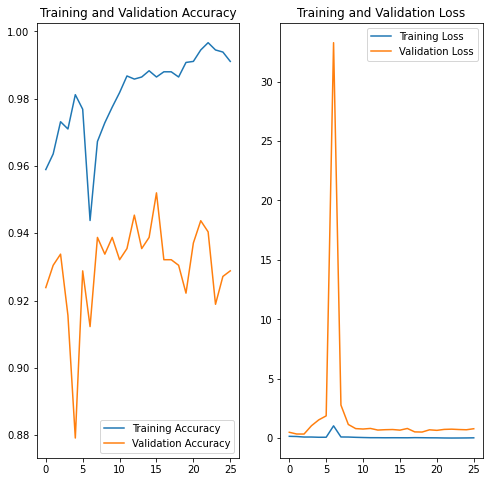

7/7 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.90 - ETA: 0s - loss: 0.3076 - accuracy: 0.95 - ETA: 0s - loss: 0.3984 - accuracy: 0.95 - ETA: 0s - loss: 0.3794 - accuracy: 0.94 - ETA: 0s - loss: 0.3058 - accuracy: 0.95 - ETA: 0s - loss: 0.2559 - accuracy: 0.96 - ETA: 0s - loss: 0.2382 - accuracy: 0.96 - 1s 182ms/step - loss: 0.2382 - accuracy: 0.9663
Loss: 0.23818445205688477
Accuracy: 0.9663461446762085


In [50]:
import datetime
import time

fit_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', min_delta=1e-4, patience=10,
        mode='max', baseline=None, restore_best_weights=True)
]

start = time.time()
history = resnet_partial.fit(train_ds, epochs=100, validation_data=val_ds, verbose=2, callbacks=fit_callbacks)
end = time.time() - start
print('Training time: {}'.format(datetime.timedelta(seconds=end)))

n_epochs_best = len(history.history['val_loss'])
filename = 'resnet_partial_besthp_fit_e{}'.format(n_epochs_best)
resnet_partial.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

loss, acc = resnet_partial.evaluate(test_ds)
print('Loss: {}\nAccuracy: {}'.format(loss, acc))